## 1. Define the utility functions

In [49]:
def cosine_sim(vec1, vec2):
    
    """Calculate cosine similarities"""
    
    return abs(np.dot(np.transpose(vec1), vec2) / np.sqrt(np.dot(np.transpose(vec1), vec1) * np.dot(np.transpose(vec2), vec2)))

In [22]:
def read_and_store(year, month):
    
    """Read monthly comments and regroup them by post"""
    
    from nltk.tokenize import RegexpTokenizer
    import bz2
    import nltk
    
    print("reading")
    
    now = time.time()
    in_path = "data/" + year + "-" + month + ".bz2"
    out_path_comments = "intermed/comments_by_post_" + year + "-" + month + ".json"
    out_path_nounverb = "intermed/noun_verb_list_" + year + "-" + month + ".json"
    
    if not os.path.isfile(out_path_nounverb):

        f_in = bz2.BZ2File(in_path).readlines()
        
        print("loaded " + str(len(f_in)) + " comments")

        tokenizer = RegexpTokenizer(r'\w*[A-z]+\w*')
        comments = [(json.loads(line)['link_id'], tokenizer.tokenize(json.loads(line)['body'].lower())) for line in f_in]
        
        documents = defaultdict(list)
        tags_of_interest = ['NN', 'NNS', 'NN$', 'VBD', 'VBP', 'VBX', 'VBG', 'VB']
        noun_verb = []
        
        print("Grouping comments")
        
        for (k,v) in comments:
            noun_verb += [i[0] for i in nltk.pos_tag(v) if i[1] in tags_of_interest]
            words = [word for word in v]
            documents[k] += words
        
        nv_list = list(set(noun_verb))

        with open(out_path_comments, 'w') as f:
            json.dump(documents, f)
        f.close()
        
        with open(out_path_nounverb, 'w') as f:
            json.dump(nv_list, f)
        f.close()
    
    else:
        
        documents = json.load(open(out_path_comments), 'r')
        nv_list = json.load(open(out_path_nounverb), 'r')

    print ("File IO took {}s.".format(time.time() - now))
    
    return documents, nv_list

In [16]:
def calculate_tfidf(documents):
    
    """Calcualte TFIDF from comments_by_post list and return the sorted TFIDF list"""
    
    from math import log
    
    now = time.time()
    tf_df = defaultdict(Counter)
    for item in documents.items():
        document = item[1]
        for word in set(document):
            tf_df[word].update(tf = document.count(word), df = 1)
            
    tfidf = {}
    N = len(documents)
    for (k, v) in tf_df.items():
        tfidf[k] = v['tf']*log(N/v['df'])
    sorted_list = sorted(tfidf.items(), key = lambda t:-t[1])
    print ("Calculating TFIDF took {}s.".format(time.time() - now))
    
    return sorted_list

In [27]:
def clean(tfidf_list, nv_list):
    
    """Remove stopwords and collect verbs and nouns"""
    
    from nltk.corpus import stopwords
    
    now = time.time()
    eng_stopwords = stopwords.words('english')
    clean_list = [i for i in tfidf_list if (not i[0] in eng_stopwords) and (len(i[0]) > 2) and (i[0] in nv_list)]
    print("Cleaning the TFIDF list took {}s".format(time.time() - now))
    
    return clean_list

In [56]:
def top_k_sim(embeddings, wordcodes, wordlist, k = 5):
    
    """Calculate similarities and return the top5 most similar words for words in wordlist"""
    # warning: wordlist is a list of (word, tf-idf) tuples

    import itertools
    
    now = time.time()
    words = [i[0] for i in wordlist]
    cos_sim = defaultdict(float)
    word_pairs = list(itertools.combinations(words, 2))
    for pair in word_pairs:
        cos_sim[pair] = cosine_sim(embeddings[wordcodes[pair[0]]], embeddings[wordcodes[pair[1]]])
    sorted_sims = sorted(cos_sim.items(), key = lambda t:(t[0][0], -t[1]))
    
    N = len(wordlist)
    top_k = []
    current_word = ""
    past_word = []
    for i, pair in enumerate(sorted_sims):
        if current_word != pair[0][0]:
            current_word = pair[0][0]
            top_k += sorted_sims[i : i + 5]

    top_k = sorted(top_k, key = lambda t:(t[0][1], -t[1]))
    
    top_k_2 = []
    counter = 0
    current_word = ""
    for pair in top_k:
        if current_word == pair[0][1]:
            counter = counter + 1
        else:
            counter = 0
            current_word = pair[0][1]
        if counter < k:
                top_k_2.append(pair)
    
    print("Calculating top similarities took {}s".format(time.time() - now))

    return top_k_2

## 2. Main function

### Import packages

In [41]:
from collections import *
import json
import time
import os.path
import numpy as np

In [23]:
documents, nv_list = read_and_store("2017", "01")

reading
loaded 156850 comments
Grouping comments
File IO took 395.51399183273315s.


In [24]:
tf_idf = calculate_tfidf(documents)

Calculating TFIDF took 158.49389696121216s.


In [28]:
clean_tf_idf = clean(tf_idf, nv_list)
top_clean = clean_tf_idf[:100]

Cleaning the TFIDF list took 180.69272089004517s


In [30]:
import pickle
trained_embeddings = pickle.load(open("intermed/updated_embeddings_tf.p", "rb+"), encoding = "latin1")
index_tf = pickle.load(open("intermed/word_to_id_tf.p", 'rb+'), encoding = "latin1")

In [33]:
index_tf["bitcoin"]

12

In [57]:
most_similar_pairs = top_k_sim(trained_embeddings, index_tf, top_clean, 5)

Calculating top similarities took 0.08345222473144531s


In [58]:
print(most_similar_pairs[:10])

[(('well', '[deleted]'), 0.579157), (('good', '[deleted]'), 0.55499965), (('china', '[deleted]'), 0.35295886), (('reddit', 'amp'), 0.40253174), (('www', 'amp'), 0.3849077), (('http', 'amp'), 0.37963185), (('comments', 'amp'), 0.35654396), (('say', 'anything'), 0.60181534), (('want', 'anything'), 0.5490133), (('something', 'anything'), 0.5439787)]


In [64]:
top_k_pairs = most_similar_pairs
with open("intermed/top_k_pairs.p", "wb+") as f:
    pickle.dump(top_k_2, f)
f.close()

In [87]:
import networkx as nx
import plotly.plotly as py
from plotly.graph_objs import *

G = nx.Graph()
edges = [(pair[0][0], pair[0][1]) for pair in top_k_pairs[:100]]
edgewidth = [pair[1]*10 for pair in top_k_pairs[:100]]
G.add_edges_from(edges)

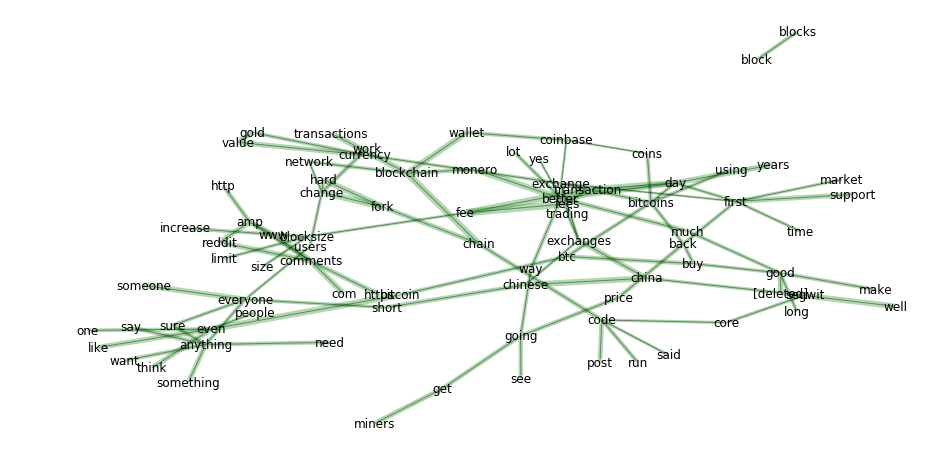

In [88]:
import matplotlib.pyplot as plt

try:
    pos = nx.nx_agraph.graphviz_layout(G)
except:
    pos = nx.spring_layout(G, iterations=20)


plt.figure(figsize=(16, 8))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edgewidth, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_size=40, node_color='w', alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.4, node_size=0, width=1, edge_color='k')
nx.draw_networkx_labels(G, pos, fontsize=16)
font = {'fontname': 'Helvetica',
        'color': 'k',
        'fontweight': 'bold',
        'fontsize': 16}
plt.axis('off')
plt.savefig("results/top_k_pairs.png", dpi = 600, bbox_inches='tight')
plt.show()

In [71]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(G)

In [77]:
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

In [78]:
sorted(map(sorted, next_level_communities))

[['[deleted]',
  'china',
  'chinese',
  'exchanges',
  'good',
  'long',
  'make',
  'trading',
  'well'],
 ['amp', 'com', 'comments', 'http', 'https', 'reddit', 'www'],
 ['anything',
  'everyone',
  'need',
  'say',
  'short',
  'someone',
  'something',
  'sure',
  'users',
  'want'],
 ['back',
  'bitcoins',
  'btc',
  'buy',
  'coinbase',
  'coins',
  'currency',
  'day',
  'exchange',
  'first',
  'gold',
  'market',
  'support',
  'time',
  'using',
  'value',
  'years'],
 ['better',
  'get',
  'going',
  'lot',
  'miners',
  'much',
  'price',
  'see',
  'way',
  'yes'],
 ['bitcoin', 'even', 'like', 'one', 'people', 'think'],
 ['block', 'blocks'],
 ['blockchain',
  'chain',
  'change',
  'code',
  'core',
  'fork',
  'hard',
  'monero',
  'network',
  'post',
  'run',
  'said',
  'segwit',
  'transactions',
  'wallet',
  'work'],
 ['blocksize', 'fee', 'fees', 'increase', 'limit', 'size', 'transaction']]